# Alexander Jannaeus vs John Hyrcanus
## Data Loading

In [66]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [67]:
from PIL import UnidentifiedImageError


# Load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                images.append(img)
            except UnidentifiedImageError:
                print(f"Skipped non-image file: {filename}")
    return images

In [68]:
# Paths and Loading
path_alex = 'alexander'
path_john = 'john'
images_alex = load_images_from_folder(path_alex)
images_john = load_images_from_folder(path_john)

Skipped non-image file: .DS_Store
Skipped non-image file: .DS_Store


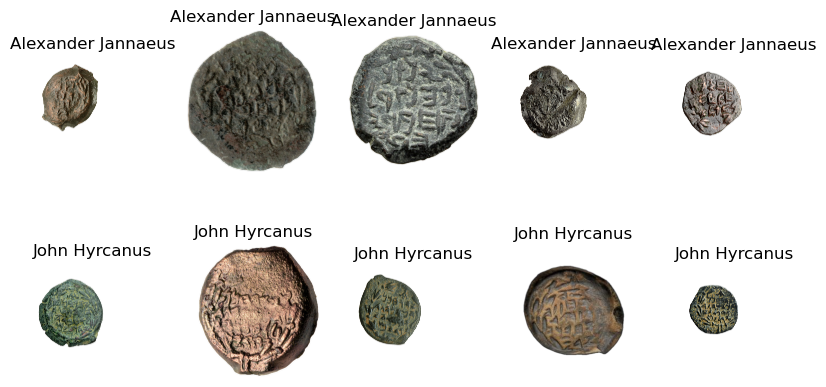

In [69]:
# Display a few samples
plt.figure(figsize=(10, 5))
for i, img in enumerate(images_alex[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Alexander Jannaeus")
    plt.axis('off')
for i, img in enumerate(images_john[:5]):
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title("John Hyrcanus")
    plt.axis('off')
plt.show()

## Data Preprocessing

In [70]:
def preprocessing_pipeline(image, steps):
    """
    Applies a sequence of preprocessing steps to an image.
    
    Parameters:
        image (numpy array): The input image.
        steps (list of functions): The list of preprocessing functions to apply.
        
    Returns:
        numpy array: The processed image.
    """
    for step in steps:
        image = step(image)
    return image

In [105]:
IMG_SIZE = (244,244)
def crop_to_coin(image):
    """
    Crops the image to the bounding box of the non-transparent region.
    """
    if image.shape[-1] == 4:  # Check for RGBA images
        alpha_channel = image[:, :, 3]  # Extract the alpha channel
        coords = cv2.findNonZero(alpha_channel)  # Find non-transparent pixels
        x, y, w, h = cv2.boundingRect(coords)  # Get the bounding box
        cropped_image = image[y:y+h, x:x+w, :3]  # Crop and keep only RGB channels
        return cropped_image
    else:
        raise ValueError("Image does not have an alpha channel. Ensure images are RGBA.")

def resize_image(image, size=IMG_SIZE):
    """
    Resizes the image to the specified size.
    """
    resized_image = cv2.resize(image, size)
    return resized_image

def normalize_image(image):
    """
    Normalizes the image to the range [0, 1].
    """
    return image / 255.0

def convert_to_grayscale(image):
    """
    Converts the image to grayscale and expands it to 3 channels.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.merge([gray, gray, gray])

In [128]:
def preprocess_image_for_text(image):
    """
    Preprocesses the image by converting it to grayscale, enhancing contrast,
    and applying adaptive thresholding to binarize the image.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhance contrast using histogram equalization
    enhanced = cv2.equalizeHist(gray)

    # Apply adaptive thresholding to highlight text
    binary = cv2.adaptiveThreshold(
        enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 7
    )

    # Expand binary to 3 channels (if needed, e.g., for MobileNet or VGG16)
    return cv2.merge([binary, binary, binary])

In [145]:
# Define the active preprocessing steps
preprocessing_steps = [
    crop_to_coin,
    resize_image,
    normalize_image
]

# Example: Process a single image
def process_images_with_pipeline(image_list, steps):
    """
    Processes a list of images using the specified pipeline steps.
    """
    processed_images = []
    for img in image_list:
        img_array = np.array(img.convert("RGBA"))  # Ensure RGBA format
        try:
            processed_img = preprocessing_pipeline(img_array, steps)
            processed_images.append(processed_img)
        except ValueError as e:
            print(f"Skipping image due to error: {e}")
    return np.array(processed_images)

# Preprocess datasets
print("Processing Alexander images...")
images_alex_processed = process_images_with_pipeline(images_alex, preprocessing_steps)

print("Processing John images...")
images_john_processed = process_images_with_pipeline(images_john, preprocessing_steps)

Processing Alexander images...
Processing John images...


In [146]:
# Create labels and combine data
labels_alex = np.zeros(len(images_alex_processed))
labels_john = np.ones(len(images_john_processed))
X = np.concatenate((images_alex_processed, images_john_processed), axis=0)
y = np.concatenate((labels_alex, labels_john), axis=0)

In [147]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [148]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (389, 244, 244, 3)
Testing data shape: (44, 244, 244, 3)
Training labels shape: (389,)
Testing labels shape: (44,)


In [149]:
# # Reshape X_train and X_test to add a single channel dimension for grayscale
# X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
# X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
# 
# # Verify shapes
# print(f"Training data shape after reshaping: {X_train.shape}")
# print(f"Testing data shape after reshaping: {X_test.shape}")

In [150]:
# datagen = ImageDataGenerator(
#     rotation_range=15,  # Reduce rotation
#     width_shift_range=0.1,  # Smaller shifts
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     rescale=1.0 / 255
# )

In [151]:
# # Display augmented images
# augmented_images = datagen.flow(X_train, y_train, batch_size=5)
# for i in range(5):
#     img = augmented_images[0][0][i]
#     plt.imshow(img)
#     plt.axis("off")
#     plt.show()

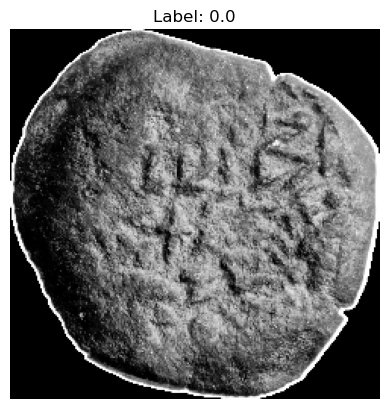

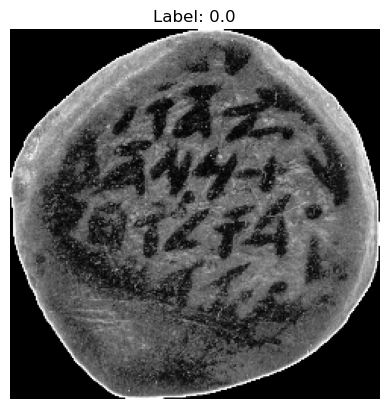

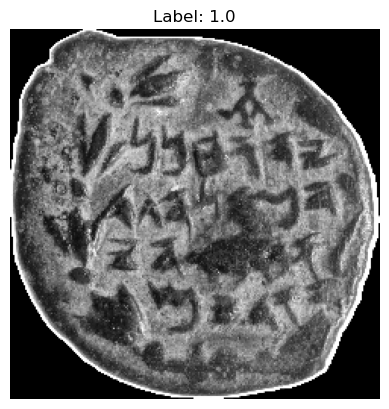

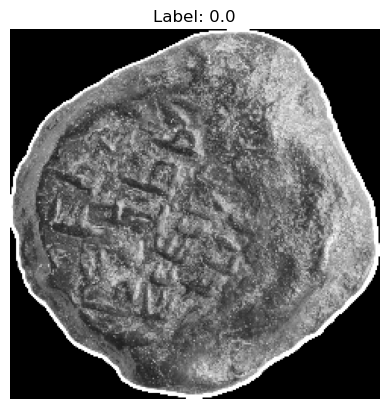

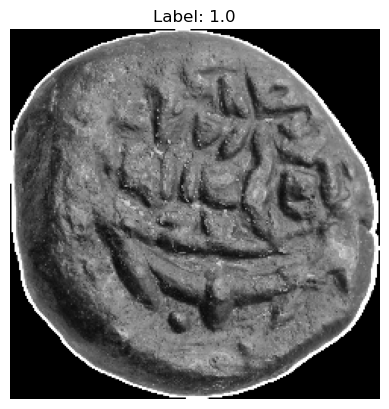

In [152]:
# Display a few training samples with labels
for i in range(5):
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
    plt.show()

## Model Building

In [153]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [154]:
epochs = 20
batch_size = 16

### MobileNetV2

In [155]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce feature dimensions
x = Dense(64, activation='relu')(x)  # Dense layer for additional learning
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Final model
modelMNV2 = Model(inputs=base_model.input, outputs=predictions)

In [156]:
# Compile model
modelMNV2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [157]:
# Train the model
historyMNV2 = modelMNV2.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss_MNV2, test_accuracy_MNV2 = modelMNV2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_MNV2:.2f}")

Epoch 1/20
25/25 [==============================] - 4s 125ms/step - loss: 0.7546 - accuracy: 0.5501 - val_loss: 0.6645 - val_accuracy: 0.5455
Epoch 2/20
25/25 [==============================] - 3s 105ms/step - loss: 0.6923 - accuracy: 0.5527 - val_loss: 0.6245 - val_accuracy: 0.6136
Epoch 3/20
25/25 [==============================] - 3s 104ms/step - loss: 0.6673 - accuracy: 0.6118 - val_loss: 0.5991 - val_accuracy: 0.6591
Epoch 4/20
25/25 [==============================] - 3s 102ms/step - loss: 0.6433 - accuracy: 0.6195 - val_loss: 0.5780 - val_accuracy: 0.7273
Epoch 5/20
25/25 [==============================] - 3s 102ms/step - loss: 0.6145 - accuracy: 0.6555 - val_loss: 0.5679 - val_accuracy: 0.7500
Epoch 6/20
25/25 [==============================] - 3s 115ms/step - loss: 0.6045 - accuracy: 0.6632 - val_loss: 0.5638 - val_accuracy: 0.7500
Epoch 7/20
25/25 [==============================] - 3s 109ms/step - loss: 0.5790 - accuracy: 0.6838 - val_loss: 0.5590 - val_accuracy: 0.7273
Epoch 

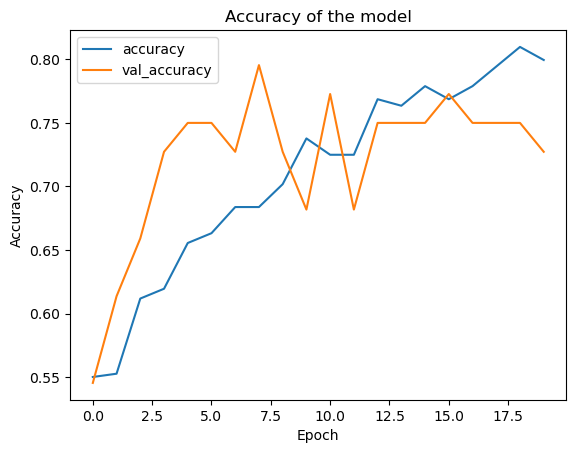

In [158]:
plt.plot(historyMNV2.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyMNV2.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG16

In [86]:
from tensorflow.keras.applications import VGG16
# VGG16 model with pre-trained weights
base_model = VGG16(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
# Freeze the base model's layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce feature dimensions
x = Dense(64, activation='relu')(x)  # Dense layer for additional learning
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Final model
modelVGG16 = Model(inputs=base_model.input, outputs=predictions)


In [87]:
# Compile model
modelVGG16.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [90]:
# Train the model
historyVGG16 = modelVGG16.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss_VGG16, test_accuracy_VGG16 = modelVGG16.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_VGG16:.2f}")

Epoch 1/20
 5/25 [=====>........................] - ETA: 24s - loss: 0.7202 - accuracy: 0.4625

KeyboardInterrupt: 

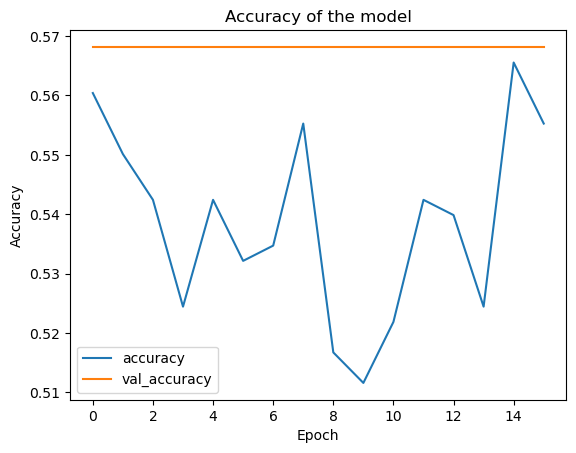

In [480]:
plt.plot(historyVGG16.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyVGG16.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Custom CNN

In [159]:
# Define model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)), # 1 for grayscale and 3 for RGB
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [160]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [161]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [162]:
# Train the model
historyCNN = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss_CNN, test_accuracy_CNN = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_CNN:.2f}")

Epoch 1/20
25/25 [==============================] - 2s 87ms/step - loss: 0.7187 - accuracy: 0.5116 - val_loss: 0.6843 - val_accuracy: 0.5682
Epoch 2/20
25/25 [==============================] - 2s 79ms/step - loss: 0.6889 - accuracy: 0.5527 - val_loss: 0.6790 - val_accuracy: 0.5682
Epoch 3/20
25/25 [==============================] - 2s 79ms/step - loss: 0.6675 - accuracy: 0.6041 - val_loss: 0.6803 - val_accuracy: 0.5682
Epoch 4/20
25/25 [==============================] - 2s 80ms/step - loss: 0.6510 - accuracy: 0.6195 - val_loss: 0.6783 - val_accuracy: 0.5909
Epoch 5/20
25/25 [==============================] - 2s 82ms/step - loss: 0.6341 - accuracy: 0.6452 - val_loss: 0.6748 - val_accuracy: 0.5682
Epoch 6/20
25/25 [==============================] - 2s 82ms/step - loss: 0.6072 - accuracy: 0.6632 - val_loss: 0.6704 - val_accuracy: 0.6136
Epoch 7/20
25/25 [==============================] - 2s 82ms/step - loss: 0.5666 - accuracy: 0.7455 - val_loss: 0.6736 - val_accuracy: 0.6136
Epoch 8/20
25

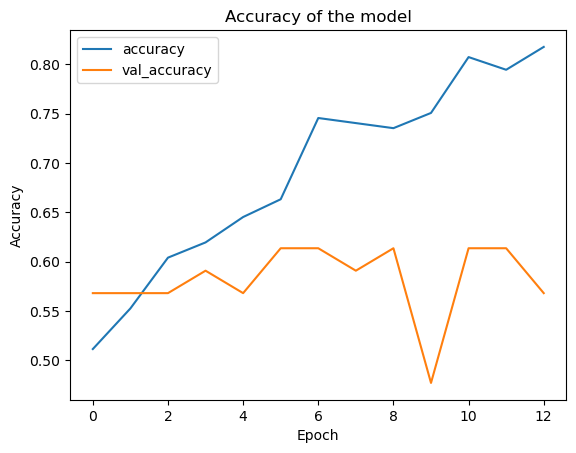

In [163]:
plt.plot(historyCNN.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyCNN.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [164]:
### Final Results Summary

# Collect results from the three models
results_summary = {
    "Model": ["MobileNetV2", "VGG16", "Custom CNN"],
    "Test Accuracy": [
        f"{test_accuracy_MNV2:.2f}",  # MobileNetV2 test accuracy
        f"{test_accuracy_VGG16:.2f}",  # VGG16 test accuracy
        f"{test_accuracy_CNN:.2f}"  # Custom CNN test accuracy
    ],
    "Test Loss": [
        f"{test_loss_MNV2:.4f}",  # MobileNetV2 test loss
        f"{test_loss_VGG16:.4f}",  # VGG16 test loss
        f"{test_loss_CNN:.4f}"  # Custom CNN test loss
    ]
}

# Display results in a clear format
import pandas as pd

results_df = pd.DataFrame(results_summary)
print(results_df)

# Optional: Save the results to a CSV for later comparison
results_df.to_csv("model_results_summary.csv", index=False)

# Display bar chart for visual comparison
plt.figure(figsize=(8, 5))
plt.bar(results_summary["Model"], [float(acc) for acc in results_summary["Test Accuracy"]])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title("Test Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'test_accuracy_VGG16' is not defined